In [3]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF
import math
import matplotlib.pyplot as plt

def yuv_to_rgb(yuv: torch.Tensor, clamp=True) -> torch.Tensor:
    m = torch.tensor([
        [1, 0.00000, 1.28033],
        [1,-0.21482,-0.38059],
        [1, 2.12798, 0.00000]], 
        device=yuv.device)
    rgb = (m @ yuv.flatten(-2)).view(yuv.shape)
    return rgb.clamp(0,1) if clamp else rgb

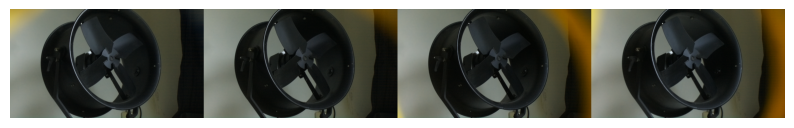

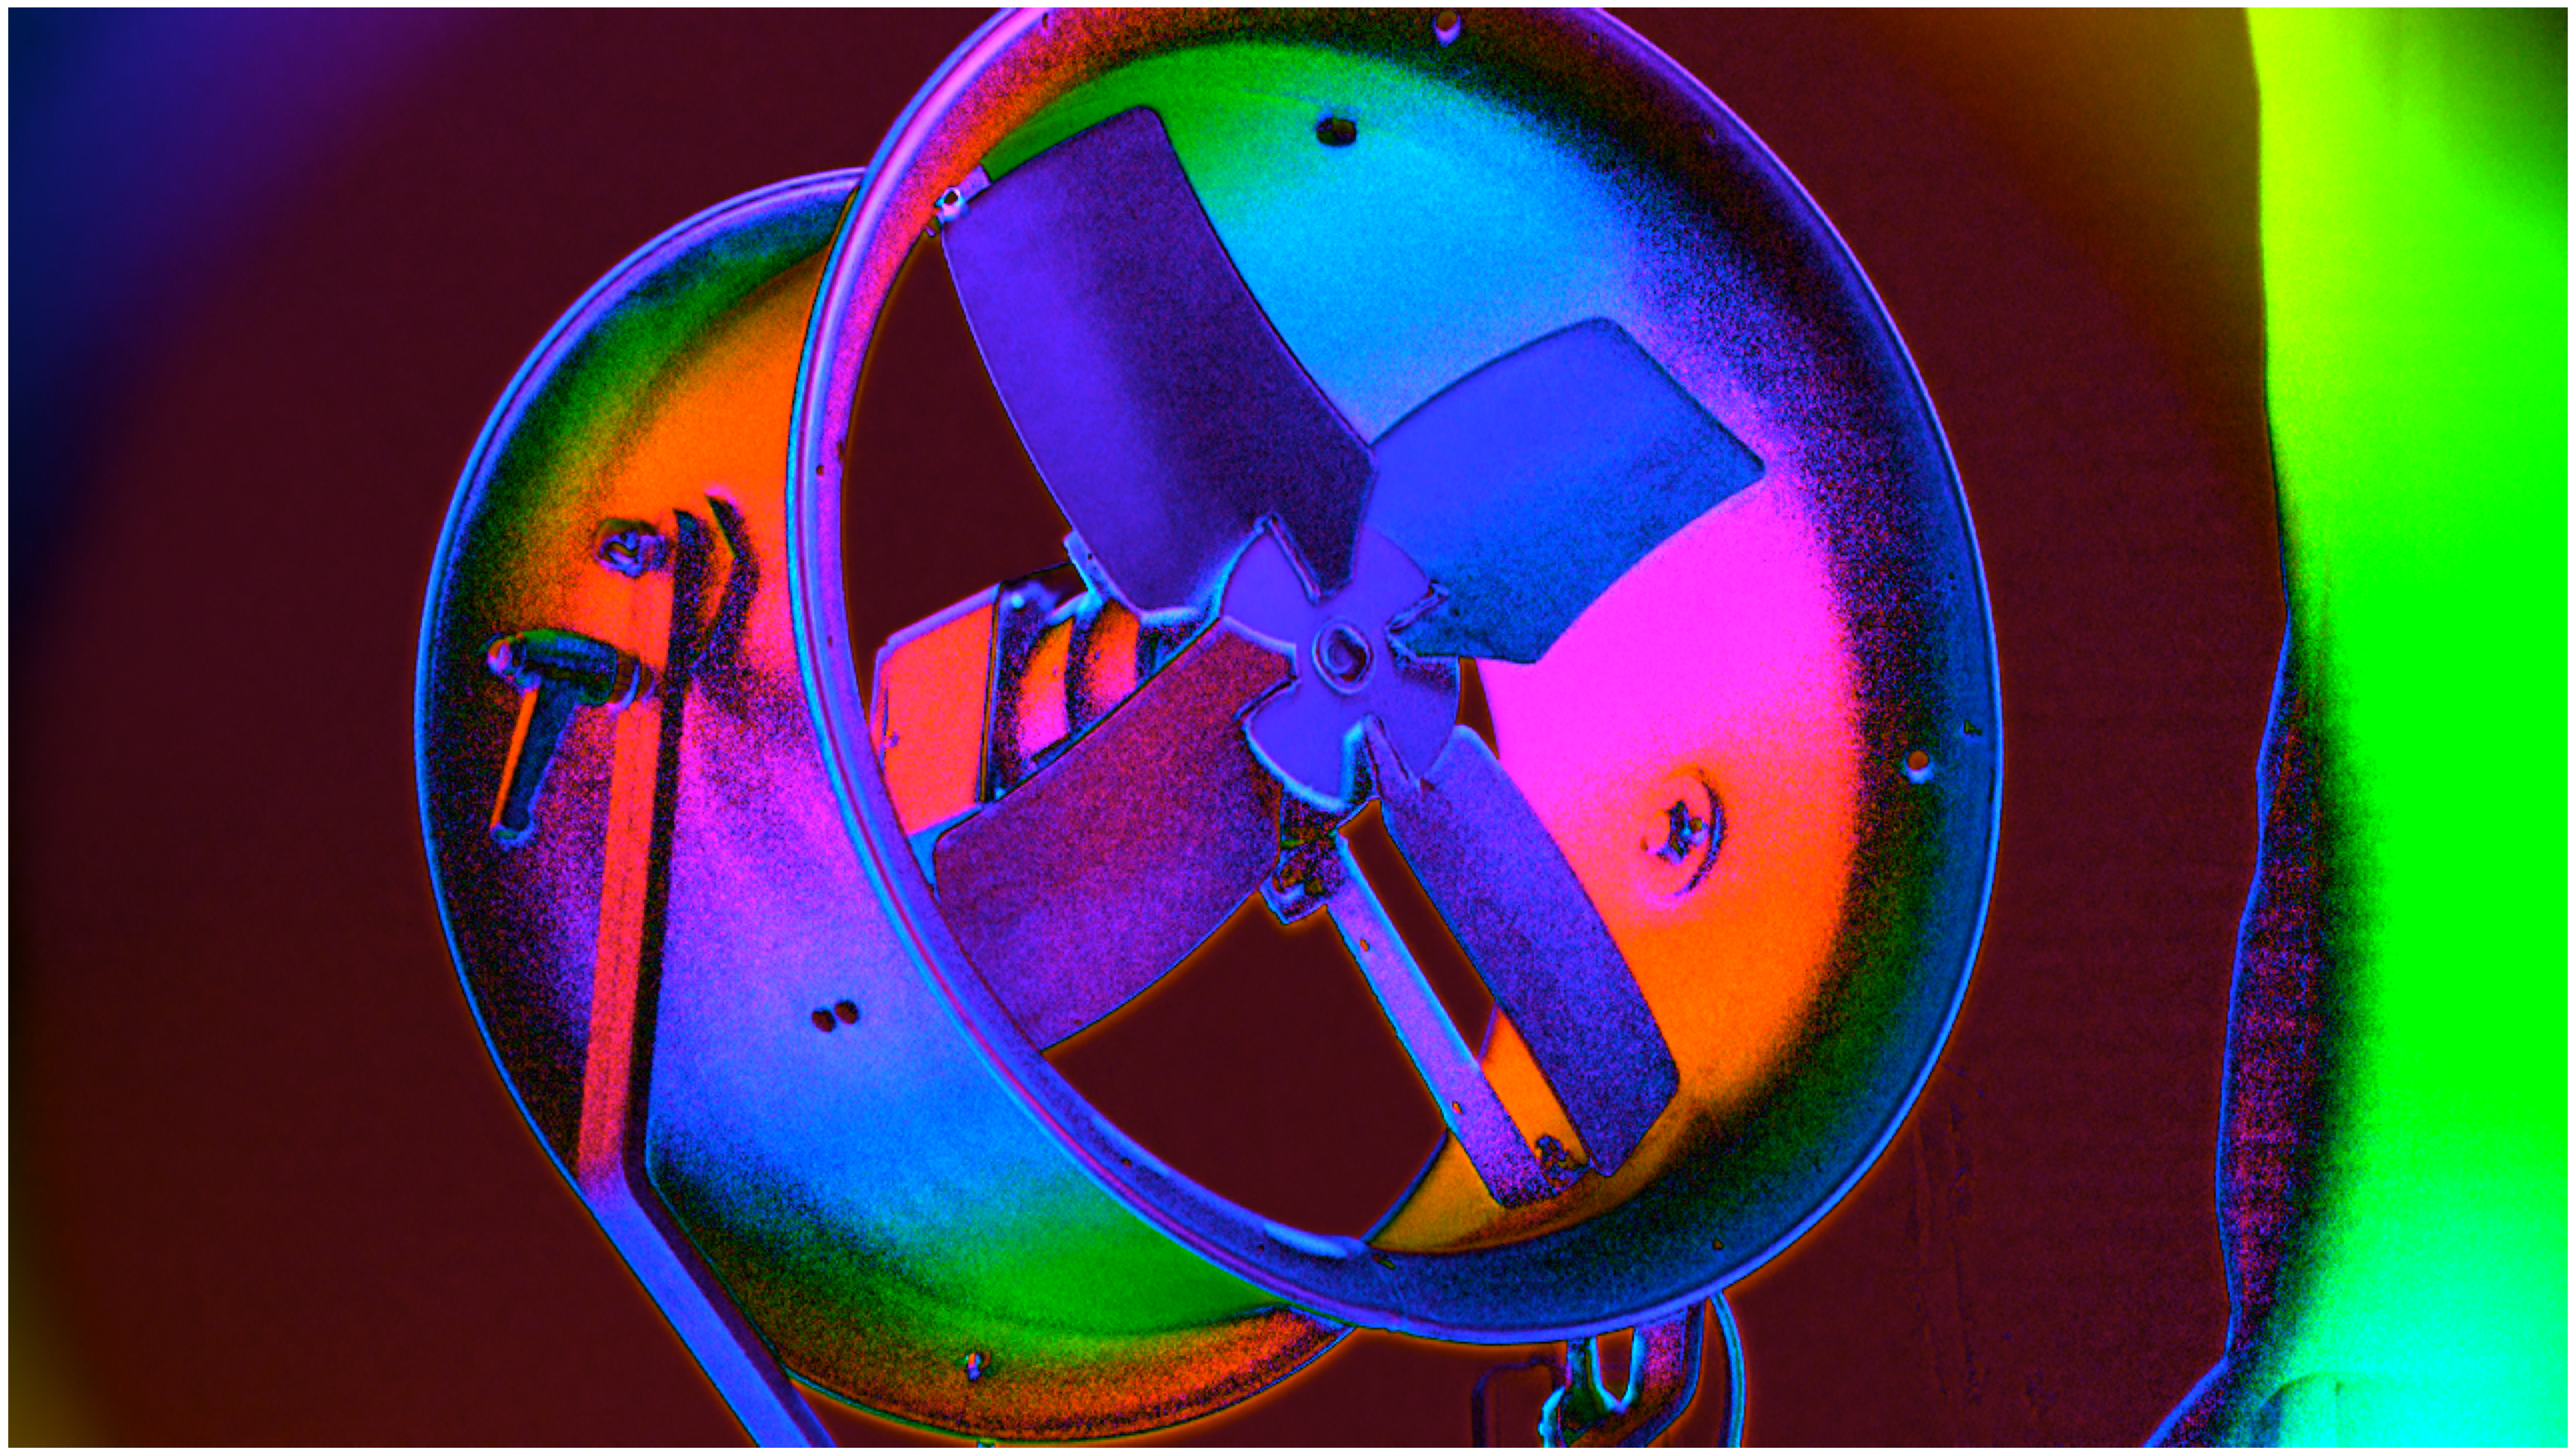

In [24]:
width = 1280
height = 720
num_frames = 30

video = []
with open("/home/wipkat/projects/polarcam/test.yuv", "rb") as stream:
    for i in range(num_frames):
        b = stream.read(int(width*height*1.5))
        size = width * height
        y,u,v = torch.frombuffer(b, dtype=torch.uint8).div(255).split([size, size//4, size//4])
        y = y.view(height,width)
        u = u.view(1,1,height//2,width//2)-0.5
        v = v.view(1,1,height//2,width//2)-0.5
        u = F.interpolate(u, (height,width), mode="bilinear")[0,0]
        v = F.interpolate(v, (height,width), mode="bilinear")[0,0]
        yuv = torch.stack((y,u,v))
        video.append(yuv)
        
video = torch.stack(video)
rgb = yuv_to_rgb(video)

# Show 4 RGB frames
plt.figure(figsize=(10,60))
plt.axis("off")
plt.imshow(torch.cat(rgb[:4].split(1,dim=0),-1)[0].permute(1,2,0))
plt.show()

# Calculate the polarimetric image
fps = 30.01
rps = 1000/149
angle_per_frame = math.pi * rps / fps
basis = 30

angles = torch.arange(basis) * angle_per_frame;
pol = video[:basis,0] * torch.complex(angles.cos(), angles.sin())[:,None,None]
pol = pol.pow(2).sum(0) /  pol.abs().pow(2).sum(0).add(1e-3)
pol = pol.sub(pol.mean()).div(pol.std().add(1e-8)) / 2
pol = yuv_to_rgb(torch.stack((pol.abs() * 0.7, pol.real, pol.imag)))

plt.figure(figsize=(40,60))
plt.axis("off")
plt.imshow(pol.permute(1,2,0))
plt.show()